# Analyzing model on SQLFlow Tutorial

The [Analyzer](../../doc/analyzer_design.md) is designed to explain the machine learning model in SQLFlow. In this tutorial, you will learn how to
- [Train an XgBoost](https://github.com/sql-machine-learning/sqlflow/blob/develop/example/jupyter/tutorial_xgboost.ipynb) tree model on [the Boston housing dataset](https://www.kaggle.com/c/boston-housing).
- Analyze the trained model using `ANALYZE` SQL statements.

You can find more SQLFlow usages from the [User Guide](https://github.com/sql-machine-learning/sqlflow/blob/develop/doc/user_guide.md).

We implement the analyzer based on [SHAP](https://github.com/slundberg/shap). By SQLFlow, an ANALYZE SQL will be translated to the SHAP code. SQLFlow enables the code to read the dataset and load the trained model, then draws a figure to explain the model. At this stage, SQLFlow supports using the [TreeExplianer](https://github.com/slundberg/shap#tree-ensemble-example-with-treeexplainer-xgboostlightgbmcatboostscikit-learn-models) to draw a summary plot.

## Syntax

```SQL
SELECT * FROM tbl
ANALYZE a_trained_model
WITH 
  shap_summary.parameter_i=value_i ...
USING TreeExplainer
```

- A standard SQL statement used to specify the dataset.
- `ANALYZE` introduces the model to explain.
- `USING TreeExplainer` restricts the explainer.
- By `WITH`, we specify the parameters to [summary_plot](https://github.com/slundberg/shap/blob/master/shap/plots/summary.py#L18-L43) with a prefix `shap_summary.`
  like: `shap_summary.plot_type="bar"`


## The dataset

We use the [boston housing](https://www.kaggle.com/c/boston-housing) as the demonstration dataset.      
First, we train a model to fit the dataset. Next, we write an `ANALYZE` SQL to get an overview of which features are most important for the model.

## Train a model

In [2]:
%%sqlflow
SELECT * FROM boston.train
TRAIN xgboost.gbtree
WITH
    objective="reg:squarederror",
    train.num_boost_round = 30
COLUMN crim, zn, indus, chas, nox, rm, age, dis, rad, tax, ptratio, b, lstat
LABEL medv
INTO sqlflow_models.my_xgb_regression_model;

[06:45:51] 387x13 matrix with 5031 entries loaded from train.txt

[06:45:51] 109x13 matrix with 1417 entries loaded from test.txt

[0]	train-rmse:17.0286	validation-rmse:17.8089

[1]	train-rmse:12.285	validation-rmse:13.2787

[2]	train-rmse:8.93071	validation-rmse:9.87677

[3]	train-rmse:6.60757	validation-rmse:7.64013

[4]	train-rmse:4.96022	validation-rmse:6.0181

[5]	train-rmse:3.80725	validation-rmse:4.95013

[6]	train-rmse:2.94382	validation-rmse:4.2357

[7]	train-rmse:2.36361	validation-rmse:3.74683

[8]	train-rmse:1.95236	validation-rmse:3.43284

[9]	train-rmse:1.66604	validation-rmse:3.20455

[10]	train-rmse:1.4738	validation-rmse:3.08947

[11]	train-rmse:1.35336	validation-rmse:3.0492

[12]	train-rmse:1.22835	validation-rmse:2.99508

[13]	train-rmse:1.15615	validation-rmse:2.98604

[14]	train-rmse:1.11082	validation-rmse:2.96433

[15]	train-rmse:1.01666	validation-rmse:2.96584

[16]	train-rmse:0.953761	validation-rmse:2.94013

[17]	train-rmse:0.905753	validation-rmse:2.91569



## Analyze the model
We can plot the SHAP values of every feature for every sample.


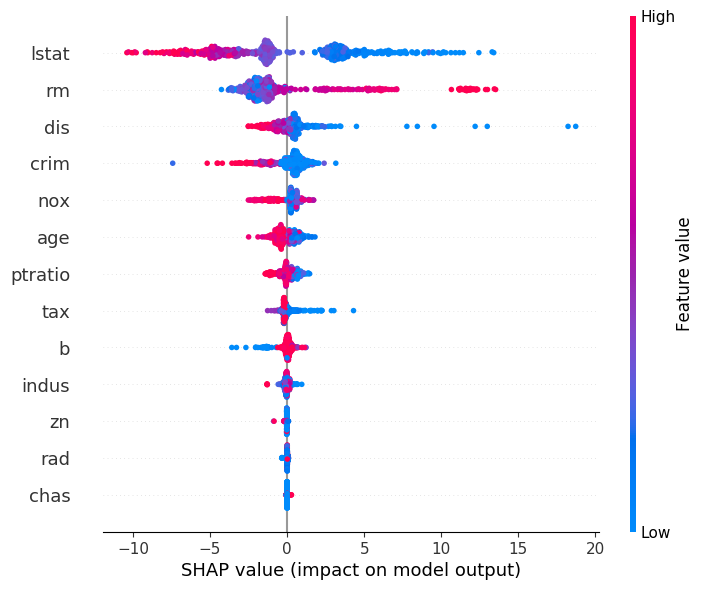

In [1]:
%%sqlflow
SELECT *
FROM boston.train
ANALYZE sqlflow_models.my_xgb_regression_model
WITH
    shap_summary.plot_type="dot",
    shap_summary.alpha=1,
    shap_summary.sort=True
USING TreeExplainer;

The plot above sorts features by the sum of SHAP value magnitudes over all samples, and use SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature values(red high, blue low). This reveals for example that a high LSTAT(% lower status of the population) lowers the predicted home price.

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot:


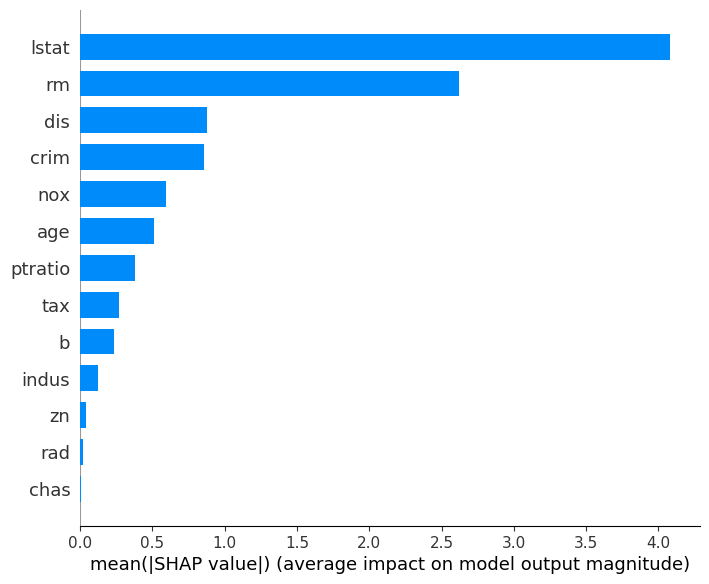

In [2]:
%%sqlflow
SELECT *
FROM boston.train
ANALYZE sqlflow_models.my_xgb_regression_model
WITH
    shap_summary.plot_type="bar",
    shap_summary.alpha=1,
    shap_summary.sort=True
USING TreeExplainer;